In [131]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both', verbose=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
info = get_info(kind='biosemi32')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]

n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    5.7s remaining:    5.7s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


# Test Procedure

## Prepare Solver

In [244]:
from invert import Solver

solver = Solver("mne", regularisation_method="GCV")
solver.make_inverse_operator(fwd, alpha="auto")

In [245]:
settings = dict(
    number_of_sources=1,
    extents=(25, 26),
    duration_of_trial=0.02,
    amplitudes=(0.1, 100),
    target_snr=1e99)

target_snrs = [1e2, 1e1, 1e0]
# target_snrs = target_snrs[::-1]
for target_snr in target_snrs:
    settings["target_snr"] = target_snr
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    # solver.make_inverse_operator(fwd, evoked, alpha="auto")
    stc_ = solver.apply_inverse_operator(evoked)


-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2005.40it/s]


source data shape:  (1284, 20) (1284, 20)


100%|██████████| 2/2 [00:00<00:00, 668.52it/s]
c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:117: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


alpha:  2.559499190363543
-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2004.45it/s]


source data shape:  (1284, 20) (1284, 20)


100%|██████████| 2/2 [00:00<00:00, 501.35it/s]

alpha:  4.666857731973757
-- number of adjacent vertices : 1284



c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:117: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<?, ?it/s]


source data shape:  (1284, 20) (1284, 20)


100%|██████████| 2/2 [00:00<00:00, 501.38it/s]
c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:117: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


alpha:  94.05294262175279


Projections have already been applied. Setting proj attribute to True.
Projections have already been applied. Setting proj attribute to True.


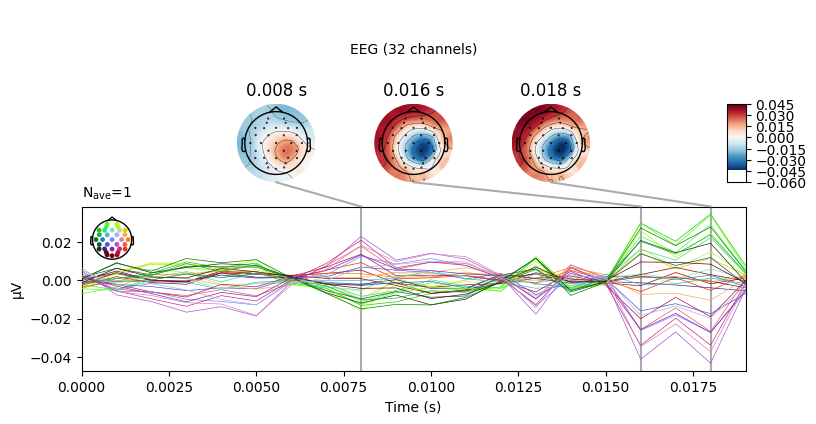

In [246]:
# stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, 'Est', 'title',
               font_size=14)
evoked_ = mne.EvokedArray(leadfield @ stc_.data, evoked.info)
evoked_.plot_joint()